In [19]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
import seaborn as sns
from matplotlib.animation import FuncAnimation

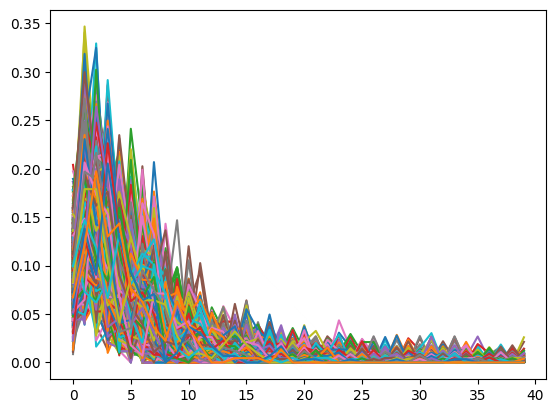

In [20]:
complete_df = pd.read_csv(project_dir / "data" / "model" / "complete_data.csv", index_col=0)
delay_df = complete_df.drop('y', axis=1)

with open(project_dir / "config.yaml", 'r') as f:
    config = yaml.safe_load(f)

MAX_DELAY = config['model']['max_delay']



for t in range(len(delay_df)):
    row = delay_df.iloc[t]
    plt.plot(list(range(0, MAX_DELAY)), row)
plt.show()


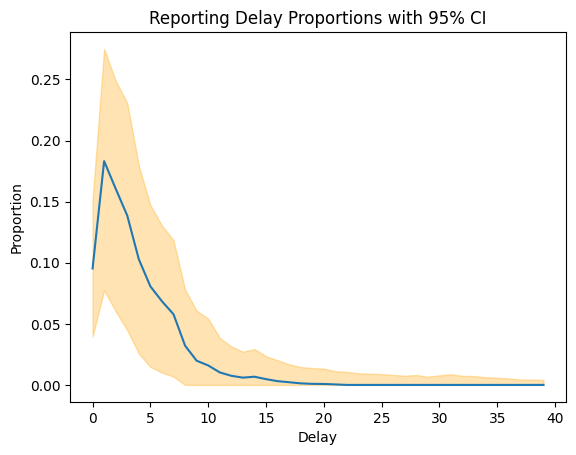

In [21]:
# Confidence intervals
median_ci = np.percentile(delay_df, 50, axis=0)
lower_ci = np.percentile(delay_df, 2.5, axis=0)
upper_ci = np.percentile(delay_df, 97.5, axis=0)

plt.plot(list(range(MAX_DELAY)), median_ci)
plt.fill_between(list(range(0, MAX_DELAY)), lower_ci, upper_ci, color='orange', alpha=0.3, label='95% CI (pred)')
plt.xlabel('Delay')
plt.ylabel('Proportion')
plt.title('Reporting Delay Proportions with 95% CI')
plt.show()


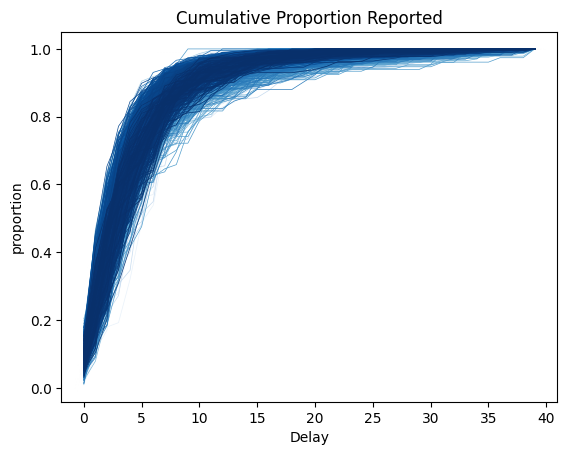

In [22]:
cmap = plt.cm.Blues
n_lines = len(cumsum_delay_df)

for t in range(n_lines):
    row = cumsum_delay_df.iloc[t]
    color = cmap(t / (n_lines - 1))
    plt.plot(list(range(0, MAX_DELAY)), row, color=color, lw=0.5)
plt.xlabel("Delay")
plt.ylabel("proportion")
plt.title("Cumulative Proportion Reported")
plt.show()

## Assess when a certain proportion of cases have been reported 

e.g after what delay were 50% of cases reported, see if this changes over time or looks to be imapcted by the total case count.

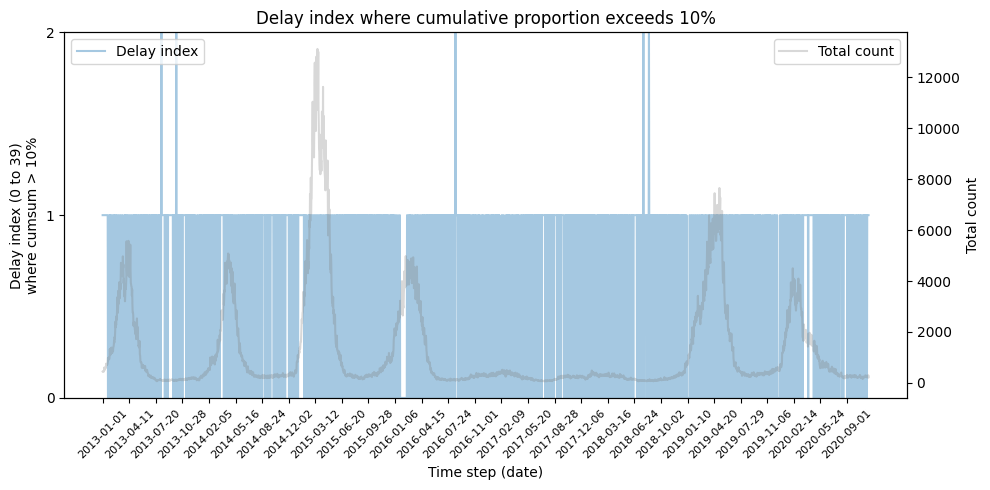

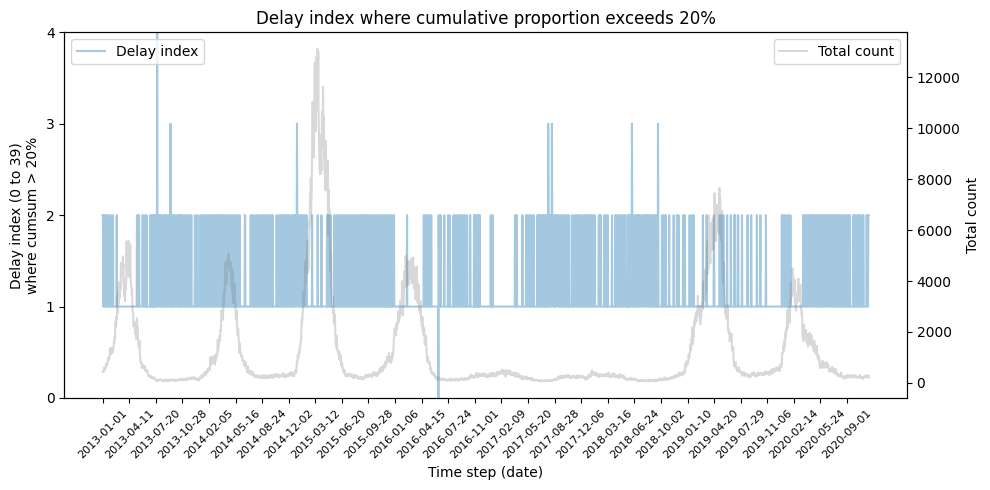

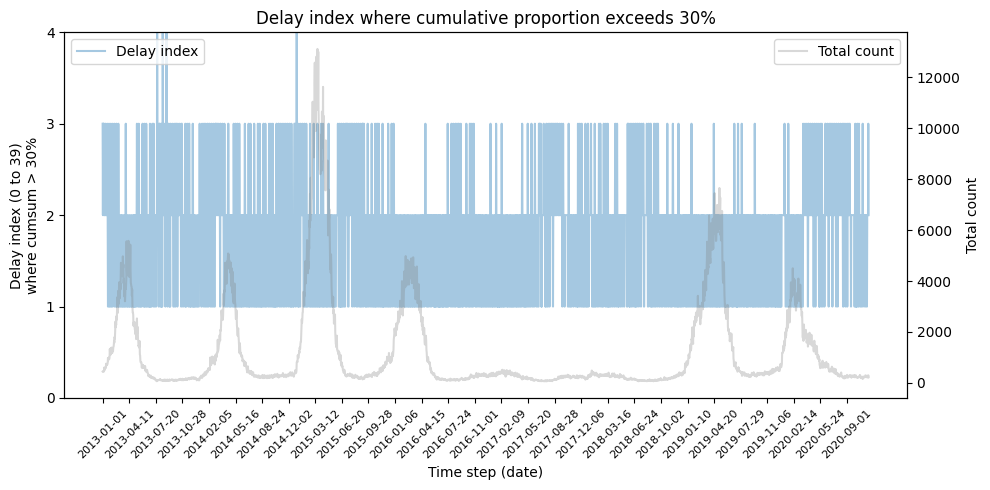

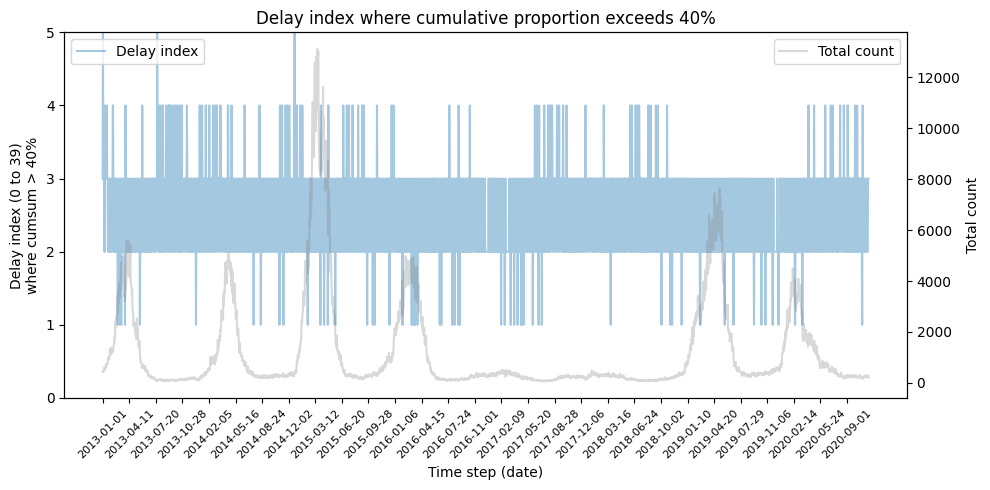

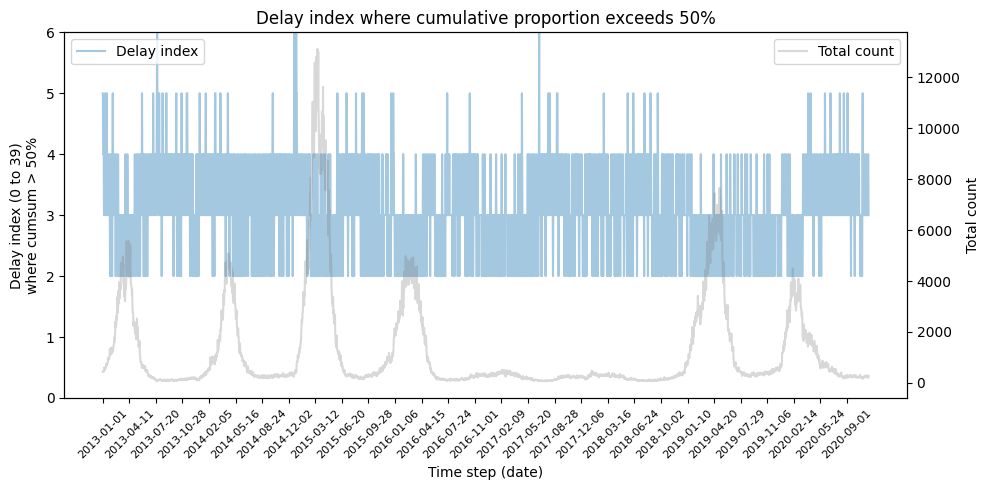

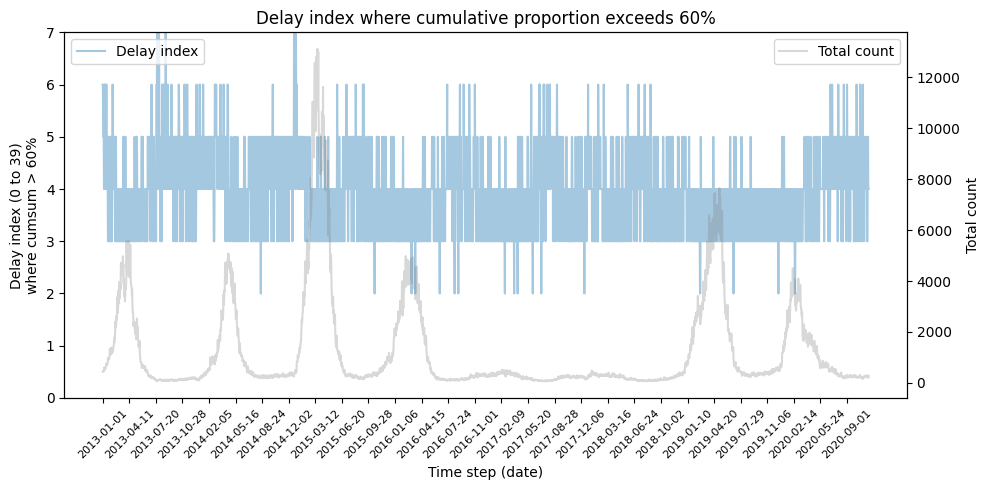

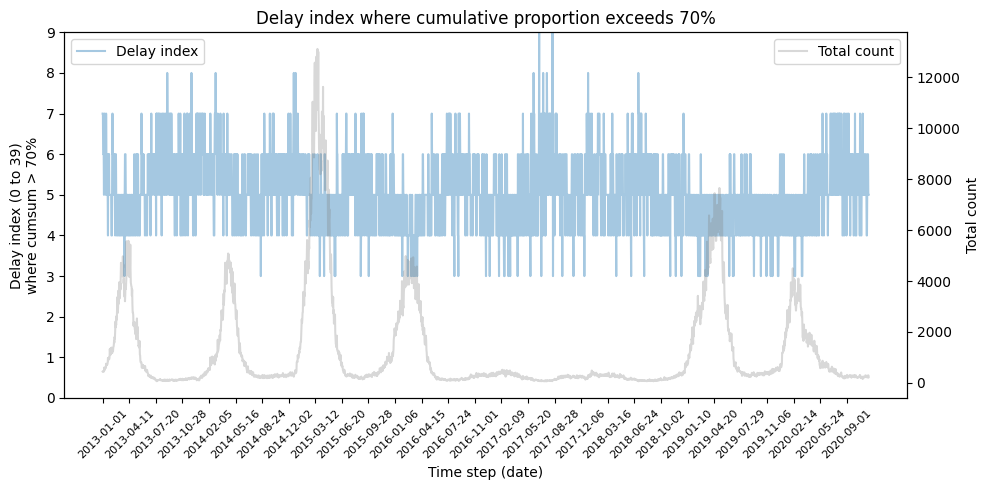

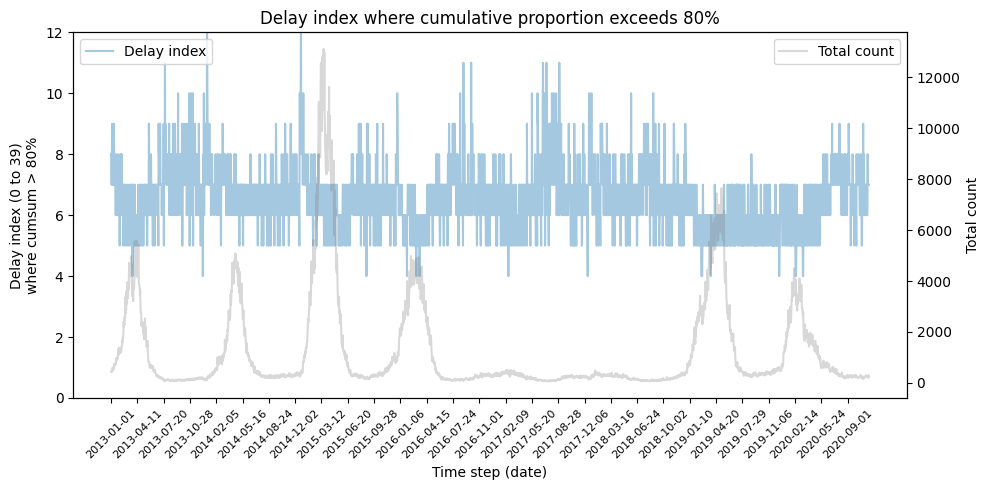

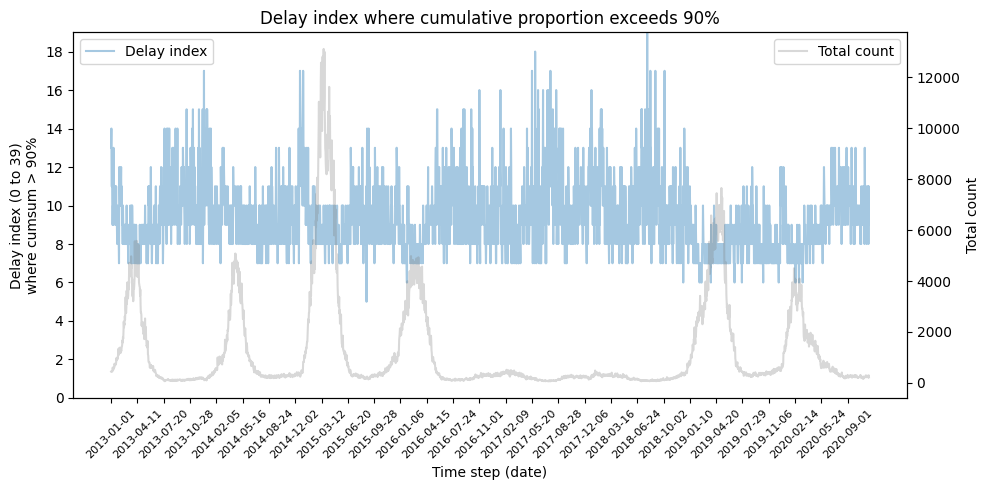

In [29]:
def plot_delay_cumulative_ts(cumsum_per, window=7, total_counts=None):
    cumsum_prop = cumsum_per / 100
    num_delays = cumsum_delay_df.shape[1]

    # For each row, get the first column label where cumsum > cumsum_prop
    first_over_labels = cumsum_delay_df.apply(lambda row: (row > cumsum_prop).idxmax(), axis=1)

    # Convert column labels to integer positions
    col_pos_map = {col: i for i, col in enumerate(cumsum_delay_df.columns)}
    first_over_pos = first_over_labels.map(col_pos_map)

    # Set up figure and axes
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Main plot: delay index
    ax1.plot(first_over_pos.index, first_over_pos.values, alpha=0.4, label='Delay index')
    ax1.set_ylabel(f'Delay index (0 to {num_delays - 1})\nwhere cumsum > {cumsum_prop*100:.0f}%')
    ax1.set_xlabel('Time step (date)')
    ax1.set_ylim(0, max(first_over_pos.values))
    ax1.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax1.legend(loc='upper left')
    ax1.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Background total count plot (if provided)
    if total_counts is not None:
        ax2 = ax1.twinx()
        ax2.plot(total_counts.index, total_counts.values, color='grey', alpha=0.3, label='Total count')
        ax2.set_ylabel('Total count')
        ax2.legend(loc='upper right')

    plt.title(f'Delay index where cumulative proportion exceeds {cumsum_prop*100:.0f}%')
    plt.tight_layout()
    plt.xticks(first_over_pos.index[::100], rotation=45, fontsize=8)
    plt.show()

total_counts = complete_df['y']

for cumsum_prop in range(10, 100, 10):
    plot_delay_cumulative_ts(cumsum_prop, total_counts=total_counts)

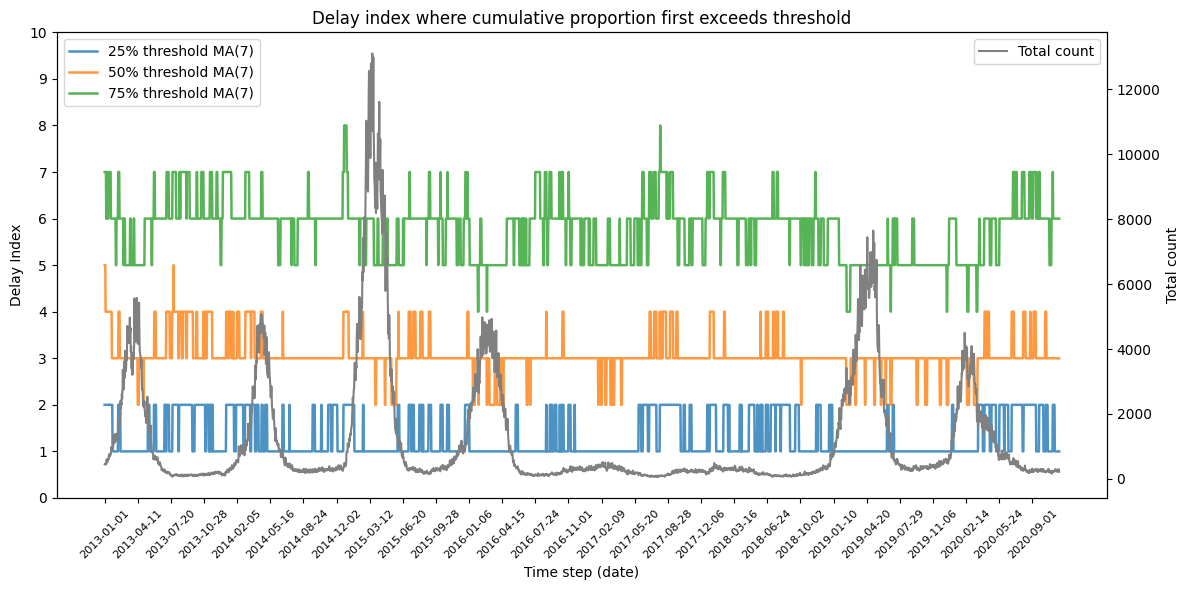

In [105]:
def plot_delay_cumulative_ts_lines(quantiles=[25, 50, 75], window=7, total_counts=None):
    sorted_df = cumsum_delay_df.sort_index()
    num_delays = sorted_df.shape[1]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Optional: background total count
    if total_counts is not None:
        total_counts_sorted = total_counts.sort_index()
        ax2 = ax1.twinx()
        ax2.plot(total_counts_sorted.index, total_counts_sorted.values, color='grey', alpha=1, label='Total count')
        ax2.set_ylabel('Total count')
        ax2.legend(loc='upper right')

    # Main loop: each threshold in a different color
    for cumsum_per in quantiles:
        cumsum_prop = cumsum_per / 100

        # Compute first delay index where cumulative prop exceeds threshold
        first_over_labels = sorted_df.apply(lambda row: (row > cumsum_prop).idxmax(), axis=1)
        col_pos_map = {col: i for i, col in enumerate(sorted_df.columns)}
        first_over_pos = first_over_labels.map(col_pos_map)

        # Smooth + round
        smoothed_delay_index = first_over_pos.rolling(window=window, min_periods=1).mean().round().astype(int)

        # Plot line
        ax1.plot(smoothed_delay_index.index, smoothed_delay_index.values,
                 label=f'{cumsum_per}% threshold MA({window})', linewidth=1.8, alpha=0.8)

    # Format axes
    ax1.set_ylabel(f'Delay Index')
    ax1.set_xlabel('Time step (date)')
    ax1.set_ylim(0, 10)
    ax1.tick_params(axis='x', rotation=45, labelsize=8)
    ax1.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax1.legend(loc='upper left')

    plt.title(f'Delay index where cumulative proportion first exceeds threshold')
    plt.tight_layout()
    plt.xticks(sorted_df.index[::100], rotation=45, fontsize=8)
    plt.show()

plot_delay_cumulative_ts_lines(quantiles=[25, 50, 75], window=7, total_counts=complete_df['y'])


Cumulative reported proportion does not appear to have any signifiacnt trends over time, although some periodicity

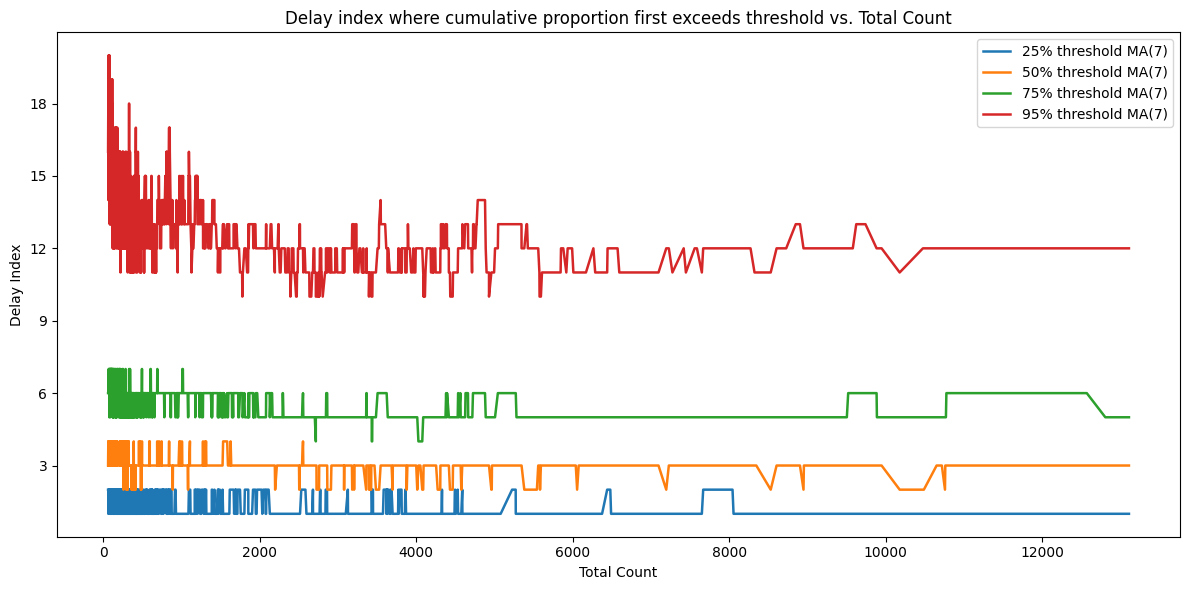

In [103]:
def plot_quantiles_vs_total_count(quantiles=[25, 50, 75], window=7):
    fig, ax = plt.subplots(figsize=(12, 6))

    for q in quantiles:
        cumsum_prop = q / 100

        # Step 1: Get first delay index where cumulative proportion exceeds threshold
        first_over_labels = cumsum_delay_df.apply(lambda row: (row > cumsum_prop).idxmax(), axis=1)

        # Step 2: Map to delay indices
        col_pos_map = {col: i for i, col in enumerate(cumsum_delay_df.columns)}
        first_over_pos = first_over_labels.map(col_pos_map)

        # Step 3: Store in complete_df
        complete_df_temp = complete_df.copy()
        complete_df_temp['q'] = first_over_pos.values

        # Step 4: Sort by total count and apply moving average
        complete_df_temp = complete_df_temp.sort_values(by='y')
        complete_df_temp['q_smooth'] = complete_df_temp['q'].rolling(window=window, min_periods=1).mean().round()

        # Step 5: Plot
        ax.plot(complete_df_temp['y'], complete_df_temp['q_smooth'], label=f'{q}% threshold MA({window})', linewidth=1.8)

    ax.set_xlabel('Total Count')
    ax.set_ylabel('Delay Index')
    ax.set_title(f'Delay index where cumulative proportion first exceeds threshold vs. Total Count')
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.legend()
    plt.tight_layout()
    plt.show()


plot_quantiles_vs_total_count(quantiles=[25, 50, 75, 95], window=7)


Higher variance for lower counts than higher counts, no clear relationships between total count and cumiulative delay proportions. Bateched reporting when case counts are lower, fewer resources/ other priorities.

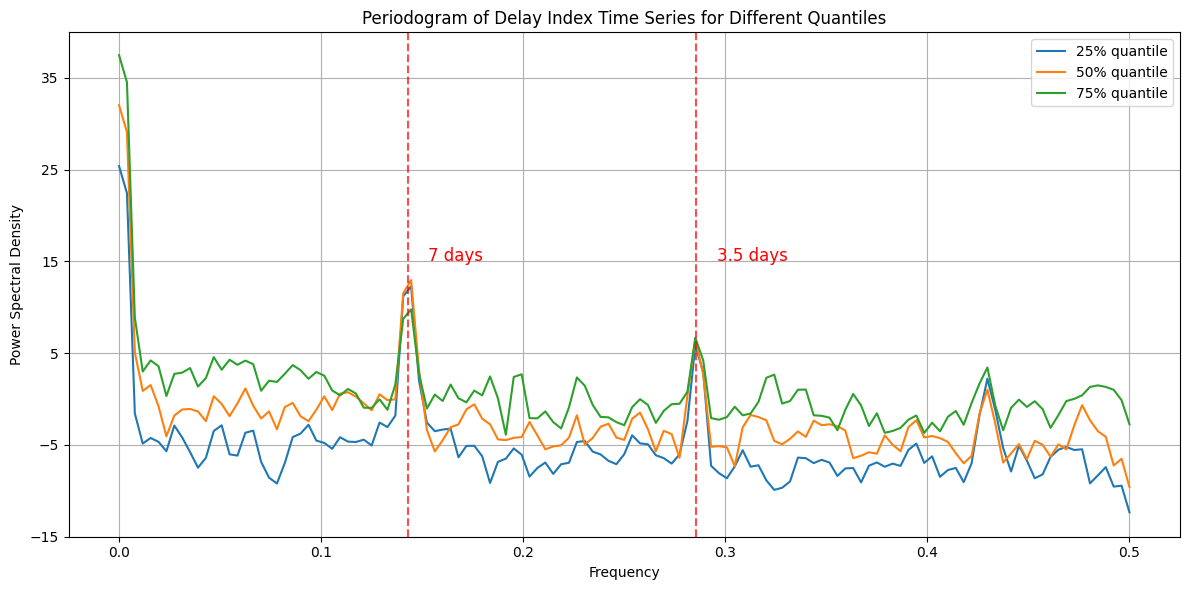

In [ ]:
import matplotlib.pyplot as plt

quantiles = [0.25, 0.5, 0.75]
col_pos_map = {col: i for i, col in enumerate(cumsum_delay_df.columns)}

plt.figure(figsize=(12, 6))

for q in quantiles:
    # Find first delay index where cumsum > q
    first_over_labels = cumsum_delay_df.apply(lambda row: (row > q).idxmax(), axis=1)
    first_over_pos = first_over_labels.map(col_pos_map)
    delay_series = first_over_pos.sort_index().values
    
    # Compute periodogram
    Pxx, freqs = plt.psd(delay_series, NFFT=256, Fs=1, label=f'{int(q*100)}% quantile')

plt.title('Periodogram of Delay Index Time Series for Different Quantiles')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.tight_layout()

for period in [3.5, 7]:
    freq = 1/period
    plt.axvline(x=freq, color='red', linestyle='--', alpha=0.7)
    plt.text(freq + 0.01, 15, f'{period} days', color='red', fontsize=12)

plt.show()


In [183]:
# Identify top 5 peaks by power
peak_indices = np.argsort(Pxx)[-5:]  # indices of top 5 power values

print("Top 5 Peaks in Periodogram:")
for i in sorted(peak_indices, key=lambda x: -psd[x]):  # sort descending
    freq = freqs[i]
    period = 1 / freq if freq > 0 else np.inf
    power = psd[i]
    print(f"Peak at frequency {freq:.4f} cycles/day -> period ≈ {period:.1f} days, power = {power:.2e}")

Top 5 Peaks in Periodogram:
Peak at frequency 0.0000 cycles/day -> period ≈ inf days, power = 5.04e+00
Peak at frequency 0.0039 cycles/day -> period ≈ 256.0 days, power = 2.58e+00
Peak at frequency 0.1406 cycles/day -> period ≈ 7.1 days, power = 4.50e-01
Peak at frequency 0.1445 cycles/day -> period ≈ 6.9 days, power = 4.19e-01
Peak at frequency 0.0078 cycles/day -> period ≈ 128.0 days, power = 1.66e-01


Likely linked to seasonal outbreaks (biannual dengue season?)